### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install cloudpickle --quiet --quiet
%pip install sentence-transformers --quiet --quiet
%pip install ipywidgets --quiet --quiet

### TODO
+ Reference policy has all examples but only randomizes over the best for each example (this solve Gumbel being a bottleneck)

### Run Demo

In [44]:
import json
from collections import defaultdict
from typing import Sequence, Callable

import torch
import coba as cb
from sentence_transformers import SentenceTransformer

from AbstractClasses import ReferencePolicy

model = SentenceTransformer('all-MiniLM-L6-v2')

def embedder(items):
    if isinstance(items,str):
        return torch.nn.functional.normalize(model.encode([items],convert_to_tensor=True))
    if isinstance(items,list):
        items = [ i['instruction'] for i in items]
        return torch.nn.functional.normalize(model.encode(items,convert_to_tensor=True))
    raise AssertionError()

def stratum(item):
    text = item if isinstance(item,str) else item['instruction']
    return 'first' if 'first' in text else 'second' if 'second' in text else 'last'

class RandomizedSimilarity(ReferencePolicy):
    def __init__(self, 
        embedder: Callable, 
        examples: Sequence, 
        ex_embeddings: Sequence, 
        batch_size: int, 
        temperature:float,
        set_size:int,
        stratum: Callable = lambda item: 1,
        preselect:int = 500) -> None:
        self._embedder = embedder
        self._batch_size = batch_size
        self._temperature = temperature
        self._set_size = set_size
        self._stratum = stratum
        self._preselect = preselect

        self._strata_examples = defaultdict(list)
        self._strata_embeddings = defaultdict(list)
        for example,embedding in zip(examples,ex_embeddings):
            self._strata_examples[stratum(example)].append(example)
            self._strata_embeddings[stratum(example)].append(embedding)
        self._strata_examples.default_factory = None
        self._strata_embeddings.default_factory = None

        for stratum,embeddings in self._strata_embeddings.items():
            self._strata_embeddings[stratum] = torch.stack(embeddings)

    @property
    def params(self):
        return {'temp':self._temperature, 'sampler':'RandomizedSimilarity', 'n_strata':len(self._strata_examples)}
    
    def sample(self, context):
        with torch.no_grad():
            context_stratum = self._stratum(context)
    
            embeddings = self._strata_embeddings[context_stratum]
            examples   = self._strata_examples[context_stratum]
            
            embedded_context = self._embedder(context)
            all_similarities = embedded_context @ embeddings.T
            top_similarities = torch.topk(all_similarities,k=self._preselect)
            similarities     = top_similarities.values
            original_indices = top_similarities.indices
            
            gumbel = torch.distributions.gumbel.Gumbel(0,1)
            gumbel_shape = torch.Size([self._batch_size, similarities.shape[1]])

            while True:
                gumbels = gumbel.sample(gumbel_shape)*self._temperature
                topks   = torch.topk(similarities+gumbels,self._set_size,dim=1).indices
                
                yield [ [ (examples[original_indices[0,i]],similarities[0,i].item()) for i in row] for row in topks ]

class FewShotFixedStrategy:
    def __init__(self, sampler:ReferencePolicy) -> None:
        self._sampler = sampler
    @property
    def params(self):
        return self._sampler.params
    def predict(self, context, actions):
        if isinstance(context,cb.Batch): raise Exception()
        action, prob = next(self._sampler.sample(context))[0],None
        return action, prob
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

class ZeroShotStrategy:
    def predict(self, context, actions):
        if isinstance(context,cb.Batch): raise Exception()
        return [],None
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

$\phi$(x,a) = \[same task, same first name, same last name, similarity score\]

use bce loss

In [55]:
from AbstractClasses import LossPredictor

class MyLossPredictor(LossPredictor):
    class LogisticRegressor(torch.nn.Module):
        def __init__(self, in_features:int):
            super().__init__()
            self.linear  = torch.nn.Linear(in_features=in_features, out_features=1)
            self.sigmoid = torch.nn.Sigmoid()

        @property
        def params(self):
            return {'type':'logistic'}
    
        def pre_logits(self, X):
            return self.linear(X)

        def loss(self, X):
            return self.sigmoid(self.pre_logits(X))

    def __init__(self, *, set_size:int, opt_factory, sched_factory) -> None:
        self._regressor = MyLossPredictor.LogisticRegressor(4*set_size)
        self.loss       = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.opt        = opt_factory(self._regressor.parameters())
        self.scheduler  = sched_factory(self.opt)
        self.y_sum      = 0
        self.t          = 0

    @property
    def params(self):
        return self._regressor.params

    def _features(self,x,a):
        features = []
        for e in a:
            i = e[0]['instruction']

            x_task = 'first' if 'first' in x else 'second' if 'second' in x else 'last'
            e_task = 'first' if 'first' in i else 'second' if 'second' in i else 'last'

            x_name = x[x.find('"')+1:x.rfind('"')]
            e_name = i[i.find('"')+1:i.rfind('"')]

            x_first,x_last = x_name.split(' ')
            e_first,e_last = e_name.split(' ')

            same_task  = int(x_task==e_task)
            same_first = int(x_first==e_first)
            same_last  = int(x_last==e_last)
            similarity = e[1]

            features.extend([same_task,same_first,same_last,similarity])
        return features

    def predict(self, context: str, actions) -> Sequence[float]:
        with torch.no_grad():
            X = torch.tensor([ self._features(context,action) for action in actions])
            return self._regressor.loss(X)

    def learn(self, contexts: torch.Tensor, actions: Sequence[float], losses: Sequence[float]) -> None:
        self.t += 1
        
        with torch.no_grad():
            X = torch.tensor([self._features(context,action) for context,action in zip(contexts,actions)])            
            y = torch.tensor(losses).float()
            self.y_sum += torch.mean(y).item()
        
        self.opt.zero_grad()
        yhat = self._regressor.pre_logits(X).squeeze(1)
        loss = self.loss(yhat,y)
        loss.mean().backward()
        self.opt.step()
        self.scheduler.step()

        with torch.no_grad():
            y_av = self.y_sum/self.t
            best_const_loss = 0 if y_av <= 0 or y_av >= 1 else self.loss(torch.logit(y_av*torch.ones_like(y)),y)
            cb.CobaContext.learning_info['loss_prediction_loss'] = loss.tolist()
            cb.CobaContext.learning_info['loss_prediction_regret'] = (loss-best_const_loss).tolist()

In [12]:
%%time
with open('LetCatTrain.jsonl',mode='rb') as f:
    examples = [ json.loads(line) for line in f ][:5000]
ex_embeddings = embedder(examples)

CPU times: total: 7.66 s
Wall time: 26.4 s


In [43]:
next(RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=30, temperature=.05, set_size=3).sample('abc'))

torch.Size([1, 500])
torch.Size([30, 3])


30

2023-07-21 14:38:35 -- pid-28768  -- Experiment Started
2023-07-21 14:38:36 -- pid-13404  -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:37 -- pid-30780  -- Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:40 -- pid-2432   -- Recording Environment 0 parameters... (0.02 seconds) (completed)
2023-07-21 14:38:40 -- pid-29492  -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:40 -- pid-13404  -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:41 -- pid-18092  -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:41 -- pid-30780  -- Recording Learner 4 parameters... (0.0 seconds) (completed)
2023-07-21 14:38:42 -- pid-29492  -- Peeking at Environment 0... (1.96 seconds) (completed)
2023-07-21 14:38:43 -- pid-13404  -- Peeking at Environment 0... (2.0 seconds) (completed)
2023-07-21 14:38:43 -- pid-18092  -- Peeking at Environment 0... (2.05 seco

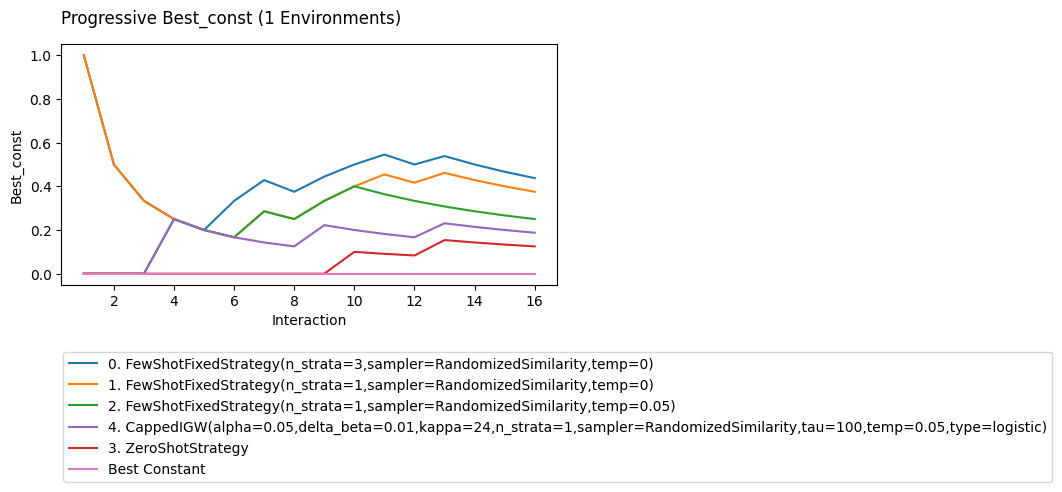

In [56]:
import torch
import coba as cb
from LetCatEnvironment import LetCatEnvironment
from CappedIGW import CappedIGW

tzero = 100
gamma_tzero = 1e-1
lr = 1e-2
batch_size = 8
n_batches = 2

rs_00_1_strat = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3, stratum=stratum)
rs_00_1       = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3)
rs_05_1       = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.05, set_size=3)
rs_05_30      = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=30, temperature=.05, set_size=3)

fhat = MyLossPredictor(
    set_size=3,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:(1+t/tzero)**(-.5))
)

env = cb.Environments(LetCatEnvironment()).take(n_batches*batch_size).batch(batch_size)
lrn = [
    FewShotFixedStrategy(rs_00_1_strat),
    FewShotFixedStrategy(rs_00_1),
    FewShotFixedStrategy(rs_05_1),
    ZeroShotStrategy(),
    CappedIGW(mu=rs_05_30, fhat=fhat, gamma_sched=lambda t: (1 + t/gamma_tzero)**(0.5))
]

result = cb.Experiment(env,lrn).run(processes=5)
result.plot_learners(out=None)
result.where(learner_id=0).plot_learners(y='best_const',colors=1+len(lrn),labels='Best Constant')

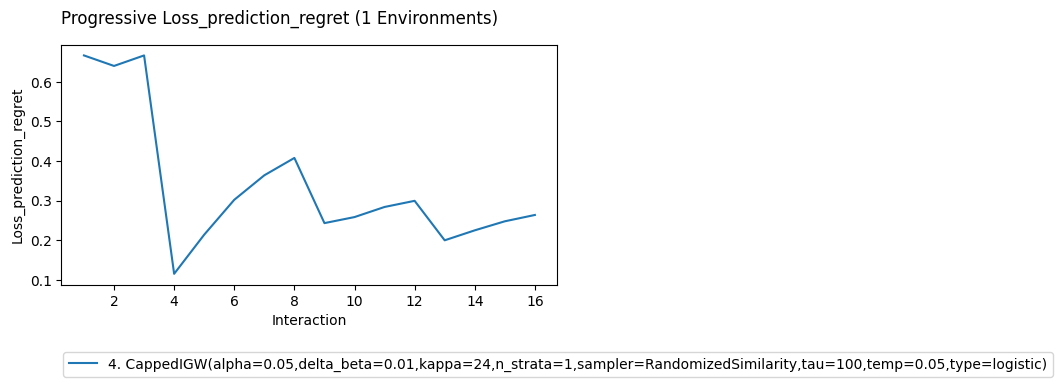

In [58]:
result.where(learner_id=4).plot_learners(y='loss_prediction_regret')

In [ ]:
hypers = random_draws(59) # <--- each of these is a tuple
lrn = [ make_learner(hypers) for h in hypers ]

In [47]:
result.learners.to_pandas()

,learner_id,alpha,delta_beta,family,kappa,n_strata,sampler,tau,temp,type
0,0,NaN,NaN,FewShotFixedStrategy,NaN,3.0,RandomizedSimilarity,NaN,0.00,None
1,1,NaN,NaN,FewShotFixedStrategy,NaN,1.0,RandomizedSimilarity,NaN,0.00,None
2,2,NaN,NaN,FewShotFixedStrategy,NaN,1.0,RandomizedSimilarity,NaN,0.05,None
3,3,NaN,NaN,ZeroShotStrategy,NaN,NaN,None,NaN,NaN,None
4,4,0.05,0.01,CappedIGW,24.0,1.0,RandomizedSimilarity,100.0,0.05,logistic


In [ ]:
result.plot_learners(out=None,xlim=(20,None))
result.where(learner_id=0).plot_learners(y='best_const',colors=4,labels='Best Constant',xlim=(20,None))